# Classifying Moon Data with Pytorch

A moon data set in ML is a two-dimensional dataset whose clusters (or classes) are distributed as two interleaving half circles

The name moon refers to the shape of each cluster distribution (resembles 2 crescent moons)

In [51]:
import pandas as pd
import sagemaker
import boto3
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import os
import numpy as np

To generate the moons dataset, we should indicate the number of datapoints we want and the noise or standard deviation. The higher the standard deviation, the more noisy our data and the higher the overlap between the two classes

In [8]:
number_points=1000
noise_moons=0.25
X_moon,y_moon=make_moons(n_samples=1000,noise=noise_moons,random_state=1)

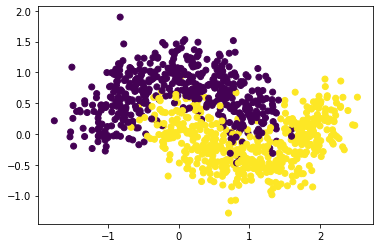

In [9]:
plt.scatter(x=X_moon[:,0],y=X_moon[:,1],c=y_moon);

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X_moon,y_moon,test_size=0.3,random_state=1)

As we plan to deploy our model in Amazon Sagemaker, we should upload the dataset to S3.

In [11]:
#create a variable with the session, the default bucket, and the role

In [12]:
sagemaker_session=sagemaker.Session()
role=sagemaker.get_execution_role()
default_bucket=sagemaker_session.default_bucket()

It is important to note that sagemaker csv files require a specific format. The files should not include headers or indexes and the labels (the Y column) should be the first column in the dataset. For that reason I will create a function to preprocess the data before uploading to S3.

In [13]:
def csv_for_sagemaker(X_train,y_train,X_test,y_test,filename,directory):
    '''
    This function takes as arguments the datasets generated by the train-test split,
    the filename we want to use to save the final train and test datasets, and the
    directory where we will save them.
    
    Returns: train, test moon data
    '''
    
    if not(os.path.exists(os.path.join(os.getcwd(),directory))):
        os.makedirs(directory)
        train_data=pd.concat([pd.DataFrame(y_train),pd.DataFrame(X_train)],axis=1)
        train_data.to_csv(os.path.join(os.getcwd(),directory,filename+'_train.csv'),index=False,header=False)
        test_data=pd.concat([pd.DataFrame(y_test),pd.DataFrame(X_test)],axis=1)
        test_data.to_csv(os.path.join(os.getcwd(),directory,filename+'_test.csv'),index=False,header=False)
        print('CSV Files created and uploaded to S3')

    else:
        print('Files already exist in the path provided')

In [14]:
csv_for_sagemaker(X_train,y_train,X_test,y_test,'moon','moon_data')

Files already exist in the path provided


The data should be uploaded to S3 so it can be used after in the training, and testing of the model

In [15]:
key_prefix='moon_data_s3'
input_data=sagemaker_session.upload_data(os.path.join(os.getcwd(),'moon_data'),default_bucket,key_prefix=key_prefix)

In [16]:
for obj in boto3.resource('s3').Bucket(default_bucket).objects.all():
     print(obj.key)

moon_data_s3/moon_test.csv
moon_data_s3/moon_train.csv


# Pytorch Model

The model will be a neural network for binary classification

In [17]:
!pygmentize source_pytorch/model.py

import torch
import torch.nn as nn #Pytorch nn classes help us train Neural networks in a more concise way. We end up with shorter, understandable and flexible code.
import torch.nn.functional as F #Functional permits us to work with built-in activation and loss function

class MLP(nn.Module):
    #nn.Module is the base class for all neural network modules
    def __init__(self,dim_input,dim_hidden,dim_output):
        '''
        Inputs:
            dim_input: Number of inputs (dimension of the input layer)
            dim_hidden: Dimension of the hiddel layer(s)
            dim_output: Number of outputs
            
        '''
        super(MLP,net).__init__()
        #creating fully connected layers
        self.fc1=nn.Linear(dim_input,dim_hidden)
        self.fc2=nn.Linear(dim_hidden,dim_output)
        self.dropout=nn.dropout(0.3)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        '''
        Feedforward behavior of the nn.
        Input:
            x: b

In [18]:
!pygmentize source_solution/train.py

from __future__ import print_function # future proof
import argparse
import sys
import os
import json

import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import SimpleNet


def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNet(model_info['input_dim'], 
                      model_info['hidden_dim'], 
                      model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
     

# Pytorch Estimator

In [38]:
from sagemaker.pytorch import PyTorch
output_path = 's3://{}/{}/'.format(default_bucket,key_prefix)
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch',
                    role=role,
                    framework_version='1.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'dim_input': 2,
                        'dim_hidden': 20,
                        'dim_output': 1,
                        'epochs': 80
                    })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [39]:
%%time 
estimator.fit({'train': input_data})

2021-03-01 03:00:42 Starting - Starting the training job...
2021-03-01 03:01:06 Starting - Launching requested ML instancesProfilerReport-1614567642: InProgress
......
2021-03-01 03:02:07 Starting - Preparing the instances for training......
2021-03-01 03:03:08 Downloading - Downloading input data......
2021-03-01 03:04:08 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-01 03:04:19,483 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-01 03:04:19,486 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-03-01 03:04:19,499 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-01 03:04:19,733 sagemaker_pytorch_container.training INFO     Invoking user training script.

2021-03-01 03:04:43 Uploading - Uploading generated training model2021-03-01 03:04:35,577 sagem

In [46]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version='py3',
                     entry_point='predict.py',
                     source_dir='source_pytorch')

In [47]:
%%time

predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 434 ms, sys: 15.5 ms, total: 450 ms
Wall time: 7min 32s


In [48]:
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [52]:
metrics = evaluate(predictor, X_test, y_test, True)

predictions  0.0  1.0
actuals              
0            141   13
1             23  123

Recall:     0.842
Precision:  0.904
Accuracy:   0.880



88% of the data points are classified correctly